# Start


In [ ]:
import os

import numpy as np
import pandas as pd
from graphviz import Source
from IPython.display import HTML, SVG
from matplotlib import pyplot as plt
from scipy.stats import zscore
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Process data


### Loading data


In [ ]:
file_path: str = "../data/raw"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")
    dataset[file] = dataset[file].drop_duplicates()

df = pd.merge(dataset["connections"], dataset["processes"], on=["imei", "ts", "mwra"])
df["ts"] = pd.to_datetime(df.ts)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

### Cleaning data


In [ ]:
number_of_rows_before_outliers = train_data.shape[0]
# 1 iteration of cleaning whole dataset of outliers (including p.android.vending)
train_data = train_data[(np.abs(zscore(train_data.iloc[:, 3:])) < 3).all(axis=1)]

# Using all columns except c.android.vending for outlier detection
columns_for_zscore = train_data.iloc[:, 3:].columns.difference(["p.android.vending"])
outliers_count = (~(np.abs(zscore(train_data[columns_for_zscore])) < 3).all(axis=1)).sum()
max_iterations = 10
iteration = 0

# Iterating after we removed all outliers
while outliers_count > 0:
    train_data = train_data[(np.abs(zscore(train_data[columns_for_zscore])) < 3).all(axis=1)]
    outliers_count = (~(np.abs(zscore(train_data[columns_for_zscore])) < 3).all(axis=1)).sum()
    iteration += 1
    if iteration >= max_iterations:
        break

train_data = train_data.reset_index(drop=True)

### Export cleaned data


In [ ]:
# Exporting cleaned data
os.makedirs("../data/clean", exist_ok=True)

train_data.to_csv("../data/clean/train_data.csv", index=False)
test_data.to_csv("../data/clean/test_data.csv", index=False)

### Import cleaned data


In [ ]:
train_data = pd.read_csv("../data/clean/train_data.csv")
test_data = pd.read_csv("../data/clean/test_data.csv")

### Define columns


In [ ]:
all_columns = train_data.drop(columns=["mwra", "ts", "imei"]).columns
non_gaussian_columns = [
    "c.android.vending",
    "c.UCMobile.x86",
    "c.updateassist",
    "c.UCMobile.intl",
    "p.android.vending",
    "p.dogalize",
    "p.olauncher",
    "p.simulator",
    "p.inputmethod.latin",
    "p.android.gms",
    "p.notifier",
    "p.katana",
    "p.gms.persistent",
]
gaussian_columns = all_columns[~all_columns.isin(non_gaussian_columns)]
transformed_feature_order = pd.Series(gaussian_columns.tolist() + non_gaussian_columns)

### Define pipelines


In [ ]:
general_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("power_transformer", PowerTransformer(method="yeo-johnson")),
    ]
)

vending_pipeline = Pipeline(
    [
        ("quantile_transformer", QuantileTransformer(output_distribution="normal", random_state=42)),
    ]
)

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("general", general_pipe, gaussian_columns),
        ("vending", vending_pipeline, non_gaussian_columns),
    ],
    remainder="passthrough",
)

# Create complete pipeline
complete_pipeline = Pipeline([("preprocessor", preprocessor)])

### Transform data


In [ ]:
# Fit and transform training data, transform test data
train_data_processed = complete_pipeline.fit_transform(train_data[all_columns], train_data["mwra"])
test_data_processed = complete_pipeline.transform(test_data[all_columns])

# Get selected features immediately after fitting
# feature_mask = complete_pipeline.named_steps["selector"].get_support()
# selected_features = transformed_feature_order[feature_mask]  # order of features is preserved

# Create DataFrames with selected feature names
train_data_processed = pd.DataFrame(train_data_processed, columns=all_columns)
test_data_processed = pd.DataFrame(test_data_processed, columns=all_columns)

train_data_processed["mwra"] = train_data["mwra"]
test_data_processed["mwra"] = test_data["mwra"]

### Export processed data


In [ ]:
os.makedirs("../data/processed", exist_ok=True)

train_data_processed.to_csv("../data/processed/train_data.csv", index=False)
test_data_processed.to_csv("../data/processed/test_data.csv", index=False)

# 3.1


-   Jednoduchý klasifikátor na základe závislosti v dátach.


In [ ]:
train_data_processed = pd.read_csv("../data/processed/train_data.csv")
test_data_processed = pd.read_csv("../data/processed/test_data.csv")

## A


-   Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň).


### Using no feature selection


In [ ]:
# Initialize the ID3 classifier
id3_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=42)

# Separate features and target variable from the training data
X_train = train_data_processed.drop(columns=["mwra"])
y_train = train_data_processed["mwra"]

# Fit the classifier to the training data
id3_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

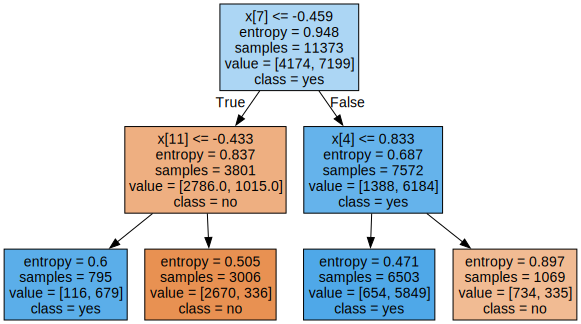

In [ ]:
graph = Source(export_graphviz(id3_classifier, out_file=None, class_names=["no", "yes"], filled=True))

display(SVG(graph.pipe(format="svg")))

style = "<style>svg{width:100%;height:70%;}</style>"
HTML(style)

### Using Feature selection


In [ ]:
selector = SelectKBest(f_classif, k=3)
X_train = train_data_processed.drop(columns=["mwra"])
y_train = train_data_processed["mwra"]

train_selected = selector.fit_transform(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]

X_train = X_train[selected_features]
X_train

,c.dogalize,c.android.youtube,c.katana,c.android.vending,c.UCMobile.x86,c.updateassist,c.UCMobile.intl,p.android.settings,p.android.documentsui,p.android.chrome
0,0.336443,0.356937,-0.471108,-1.845366,0.905799,0.770743,-0.215696,0.320906,-0.586070,-0.330074
1,-0.017029,-1.439311,1.427039,1.382006,-0.854666,-2.235996,-2.112083,0.909888,-0.357192,0.343391
2,1.442618,1.565222,-0.657138,-0.455995,-0.493118,0.259280,0.560811,-1.089356,1.017925,-2.547252
3,0.733833,-0.126543,-0.170274,0.029227,0.408417,0.376442,0.255168,-0.697553,0.452600,-1.891492
4,-0.441471,-0.136153,-0.568300,-0.786650,-1.826063,-0.557302,0.231045,0.831789,1.496241,0.323278
...,...,...,...,...,...,...,...,...,...,...
11368,1.266946,-1.009026,-0.344386,0.262482,-0.035278,-0.973817,0.835032,-0.224378,-1.156685,-0.413327
11369,1.289497,-0.374192,0.081617,0.608011,-1.066703,-1.552741,1.008366,-1.117459,0.153950,-0.085048
11370,-0.725505,-1.266224,1.326060,0.072599,0.316867,-1.154704,0.493684,-0.321457,0.646016,0.460935
11371,0.092056,-1.378173,-1.070663,-1.089409,0.327531,1.526104,-0.677560,-0.729352,-0.002804,-1.297999


In [ ]:
# Initialize the ID3 classifier
id3_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=42)

# Separate features and target variable from the training data
X_train = train_data_processed.drop(columns=["mwra"])
y_train = train_data_processed["mwra"]

# Fit the classifier to the training data
id3_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

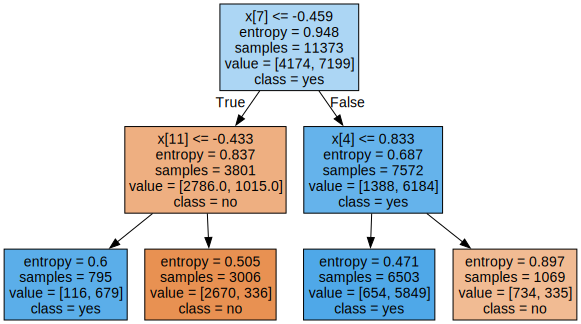

In [ ]:
graph = Source(export_graphviz(id3_classifier, out_file=None, class_names=["no", "yes"], filled=True))

display(SVG(graph.pipe(format="svg")))

style = "<style>svg{width:100%;height:70%;}</style>"
HTML(style)

## B


-   Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predict the target variable for the training data
y_pred_train = id3_classifier.predict(X_train)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

## C


-   Zístite či Váš ID3 klasifikátor má overfit.


# 3.2


-   Trénovanie a vyhodnotenie klasifikátorov strojového učenia.


## A


-   Na trénovanie využite jeden stromový algoritmus v scikit-learn.


## B


-   Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.


## C


-   Porovnajte výsledky s ID3 z prvého kroku.


## D


-   Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus.


## E


-   Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall.


# 3.3


-   Optimalizácia alias hyperparameter tuning.


## A


-   Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak,
    aby ste optimalizovali výkonnosť (bez underfitingu).


## B


-   Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste
    optimalizovali výkonnosť (bez underfitingu) .


## C


-   Využite krížovú validáciu (cross validation) na trénovacej množine.


## D


-   Dokážte že Váš nastavený najlepší model je bez overfitingu.


# 3.4


-   Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu.


## A


-   Stratégie riešenia chýbajúcich hodnôt a outlierov.


## B


-   Dátová transformácia (scaling, transformer, ...).


## C


-   Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning.


## D


-   Ktorý model je Váš najlepší model pre nasadenie (deployment)?


## E


-   Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?
